# Proje: MS Hastaları İçin Engellilik Skoru (EDSS) Tahmini - ResNet 50

**Amaç:** Bu proje, MS hastalarının beyin MR görüntülerinden doğrudan elde edilen verileri kullanarak, engellilik skorları olan EDSS'i tahmin etmeyi amaçlar.

**Yaklaşım:** Bu bir regresyon problemidir. Girdi olarak lezyon içeren MRI görüntülerini kullanıp, çıktı olarak sürekli bir sayısal değer (EDSS) üreten ve transfer öğrenme ile eğitilmiş bir ResNet50 CNN modeli kullanılacaktır.

# Adım 1: Gerekli Kütüphaneleri Import Etme, Sabit Değişkenleri Atama ve GPU'yu Test Etme

In [3]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

In [ ]:
# Sabit değerler
TARGET_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.0001

# Dosya yolları
mri_base_path = "../BrainCancerClassification/BrainCancerClassification/Data/MultipleSclerosisMRI"
MODEL_NAME = 'RESNET50_EDSS_Prediction.h5'
OUTPUT_DIR = 'ML-Models'
MODEL_PATH = os.path.join(OUTPUT_DIR, MODEL_NAME)

In [5]:
print("--- Setting up GPU memory ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
print("--- GPU setup complete ---")

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

--- Setting up GPU memory ---
1 Physical GPUs, 1 Logical GPUs
--- GPU setup complete ---
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


# Adım 2: Veri İşleme ve Model Tanım Fonksiyonlarının Tanımları

In [6]:
def normalize_image(img):
    img = img.astype(np.float32)
    min_val, max_val = np.min(img), np.max(img)
    if max_val > min_val:
        return (img - min_val) / (max_val - min_val)
    return img

def load_and_process_patient_data(patient_folder, metadata_df):
    pid = int(patient_folder.split("-")[-1])
    
    edss_score = metadata_df.loc[metadata_df["PatientID"] == pid, "EDSS"].values
    if len(edss_score) == 0:
        return None, None
    edss_score = float(edss_score[0])
    
    try:
        flair_path = os.path.join(mri_base_path, patient_folder, f"{pid}-Flair.nii")
        seg_path = os.path.join(mri_base_path, patient_folder, f"{pid}-LesionSeg-Flair.nii")
        
        flair_data = normalize_image(nib.load(flair_path).get_fdata())
        seg_data = nib.load(seg_path).get_fdata()
        
        lesion_slices = []
        for i in range(flair_data.shape[2]):
            if np.count_nonzero(seg_data[:, :, i]) > 0: 
                slice_2d = flair_data[:, :, i]
                resized_slice = resize(slice_2d, TARGET_SIZE, preserve_range=True)
                image_3channel = np.stack([resized_slice] * 3, axis=-1).astype(np.float32)
                lesion_slices.append(image_3channel)
        
        return lesion_slices, edss_score
    
    except Exception as e:
        print(f"Hasta {pid} işlenirken hata: {e}")
        return None, None
    
def create_edss_model(input_shape):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = False
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    outputs = tf.keras.layers.Dense(1, activation='linear', dtype='float32')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

# Adım 3: Veri Yükleme ve Hazırlık

In [ ]:
# Hasta klasörlerini listele
patient_folders = sorted([f for f in os.listdir(mri_base_path) if f.startswith("Patient")])
print(f"Toplam hasta sayısı: {len(patient_folders)}")

# Klinik verileri yükle
clinical_df = pd.read_excel(os.path.join(mri_base_path, "InfoPatient.xlsx"), header=1)
clinical_df.rename(columns={"ID": "PatientID"}, inplace=True)

# EDSS değerlerinin dağılımını kontrol et
print(f"EDSS değerlerinin dağılımı:")
print(clinical_df['EDSS'].describe())
print(f"EDSS değer aralığı: {clinical_df['EDSS'].min()} - {clinical_df['EDSS'].max()}")

# Veri setini hazırla
all_images = []
all_edss_scores = []

print("Hasta verileri işleniyor...")
for folder in tqdm(patient_folders):
    lesion_slices, edss_score = load_and_process_patient_data(folder, clinical_df)
    
    if lesion_slices and edss_score is not None:
        max_slices = min(5, len(lesion_slices))
        selected_slices = lesion_slices[:max_slices]
        
        for slice_img in selected_slices:
            all_images.append(slice_img)
            all_edss_scores.append(edss_score)

print(f"Toplam görüntü sayısı: {len(all_images)}")
print(f"Toplam EDSS etiketi sayısı: {len(all_edss_scores)}")

# Numpy arrays'e çevir
X = np.array(all_images)
y = np.array(all_edss_scores)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Veri setini böl
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Eğitim seti: {X_train.shape[0]} örnek")
print(f"Doğrulama seti: {X_val.shape[0]} örnek")
print(f"Test seti: {X_test.shape[0]} örnek")

Toplam hasta sayısı: 60
EDSS değerlerinin dağılımı:
count    60.000000
mean      2.266667
std       1.595722
min       0.000000
25%       1.000000
50%       2.000000
75%       3.500000
max       6.000000
Name: EDSS, dtype: float64
EDSS değer aralığı: 0.0 - 6.0
Hasta verileri işleniyor...


100%|██████████| 60/60 [00:05<00:00, 10.27it/s]

Toplam görüntü sayısı: 299
Toplam EDSS etiketi sayısı: 299
X shape: (299, 224, 224, 3)
y shape: (299,)
Eğitim seti: 209 örnek
Doğrulama seti: 45 örnek
Test seti: 45 örnek


# Adım 4: Modelin Oluşturulması, Derlenmesi, Eğitim ve Callback'ler

In [11]:
model = create_edss_model(input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='mse',  # Mean Squared Error
    metrics=['mae']  # Mean Absolute Error
)

model.summary()

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_NAME,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

print("Model eğitimi başlıyor...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                           

# Adım 5: Fine-Tuning

In [9]:
print("\n=== Fine-tuning ===")

base_model = model.layers[1] 
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
    loss='mse',
    metrics=['mae']
)

print(f"Fine-tuning için eğitilebilir parametreler: {model.count_params()}")

# Fine-tuning
history_ft = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)



=== Fine-tuning ===
Fine-tuning için eğitilebilir parametreler: 24145281
Epoch 1/20
14/14 [==============================] - 6s 225ms/step - loss: 2.8643 - mae: 1.3856 - val_loss: 2.5787 - val_mae: 1.4337 - lr: 1.0000e-05
Epoch 2/20
14/14 [==============================] - 4s 280ms/step - loss: 2.8463 - mae: 1.3883 - val_loss: 2.6670 - val_mae: 1.4675 - lr: 1.0000e-05
Epoch 3/20
14/14 [==============================] - 2s 177ms/step - loss: 2.9121 - mae: 1.4073 - val_loss: 2.5325 - val_mae: 1.3496 - lr: 1.0000e-05
Epoch 4/20
14/14 [==============================] - 3s 196ms/step - loss: 2.6403 - mae: 1.3468 - val_loss: 2.5655 - val_mae: 1.4224 - lr: 1.0000e-05
Epoch 5/20
14/14 [==============================] - 1s 102ms/step - loss: 2.4364 - mae: 1.3070 - val_loss: 2.6557 - val_mae: 1.4605 - lr: 1.0000e-05
Epoch 6/20
14/14 [==============================] - 2s 114ms/step - loss: 2.6071 - mae: 1.3821 - val_loss: 2.6001 - val_mae: 1.4350 - lr: 1.0000e-05
Epoch 7/20
14/14 [==============

# Adım 6: Modelin Nihai Değerlendirmesi ve Raporlanması


=== Model Değerlendirmesi ===
2/2 [==============================] - 1s 259ms/step
Test Seti Sonuçları:
MSE: 2.6148
MAE: 1.4275
RMSE: 1.6170
R²: -0.0170


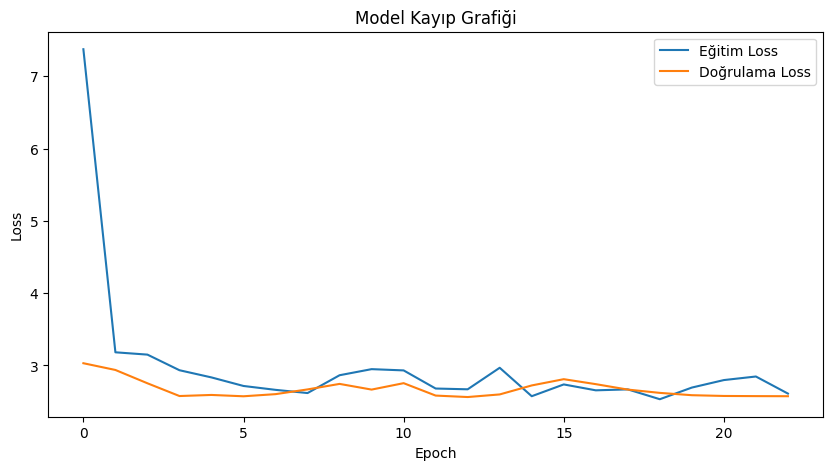

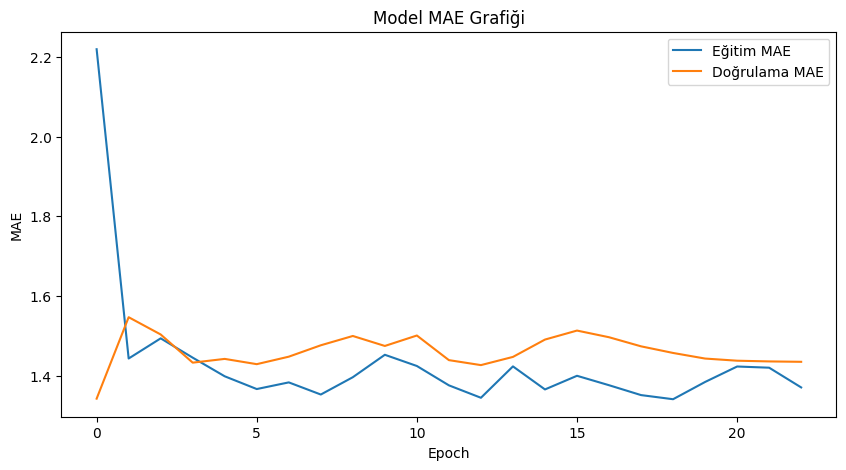

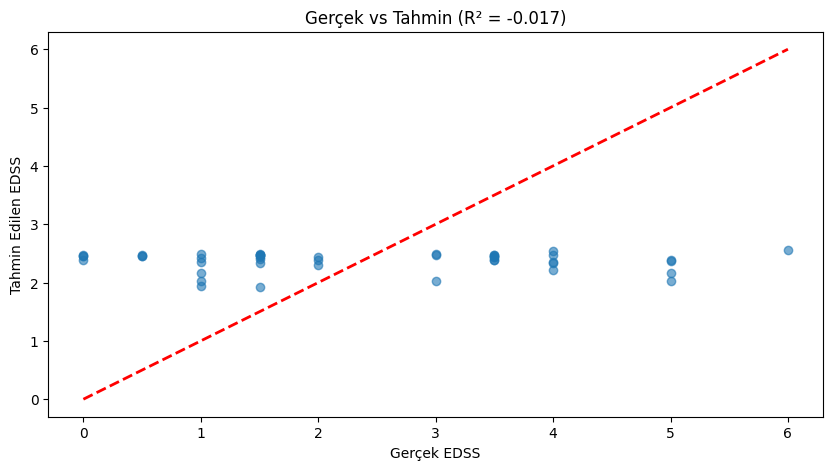


=== Örnek Tahminler ===
Gerçek: 1.50, Tahmin: 2.48, Fark: 0.98
Gerçek: 3.50, Tahmin: 2.45, Fark: 1.05
Gerçek: 1.50, Tahmin: 2.44, Fark: 0.94
Gerçek: 0.00, Tahmin: 2.47, Fark: 2.47
Gerçek: 4.00, Tahmin: 2.34, Fark: 1.66
Gerçek: 4.00, Tahmin: 2.36, Fark: 1.64
Gerçek: 0.50, Tahmin: 2.45, Fark: 1.95
Gerçek: 5.00, Tahmin: 2.36, Fark: 2.64
Gerçek: 1.50, Tahmin: 1.93, Fark: 0.43
Gerçek: 4.00, Tahmin: 2.54, Fark: 1.46

Model 'RESNET50_EDSS_Prediction.h5' olarak kaydedildi.

=== Özet ===
- Toplam 299 görüntü ile eğitim yapıldı
- Test seti MAE: 1.4275
- Test seti R²: -0.0170
- Model başarıyla kaydedildi


In [10]:
print("\n=== Model Değerlendirmesi ===")

y_pred = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test Seti Sonuçları:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Eğitim Kaybı ve Doğrulama Kaybı Grafiği
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Eğitim Loss')
plt.plot(history.history['val_loss'], label='Doğrulama Loss')
plt.title('Model Kayıp Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Eğitim MAE ve Doğrulama MAE Grafiği
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Eğitim MAE')
plt.plot(history.history['val_mae'], label='Doğrulama MAE')
plt.title('Model MAE Grafiği')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Gerçek EDSS vs Tahmin Edilen EDSS Grafiği
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Gerçek EDSS')
plt.ylabel('Tahmin Edilen EDSS')
plt.title(f'Gerçek vs Tahmin (R² = {r2:.3f})')
plt.show()

print(f"\n=== Örnek Tahminler ===")
for i in range(min(10, len(y_test))):
    print(f"Gerçek: {y_test[i]:.2f}, Tahmin: {y_pred[i]:.2f}, Fark: {abs(y_test[i] - y_pred[i]):.2f}")

model.save(MODEL_PATH)
print(f"\nModel '{MODEL_NAME}' olarak kaydedildi.")

print(f"\n=== Özet ===")
print(f"- Toplam {len(all_images)} görüntü ile eğitim yapıldı")
print(f"- Test seti MAE: {mae:.4f}")
print(f"- Test seti R²: {r2:.4f}")
print(f"- Model başarıyla kaydedildi")